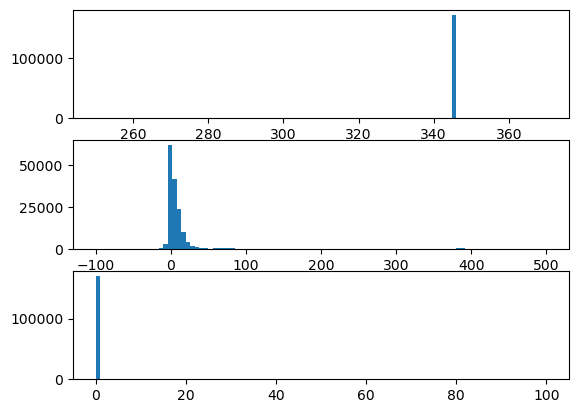

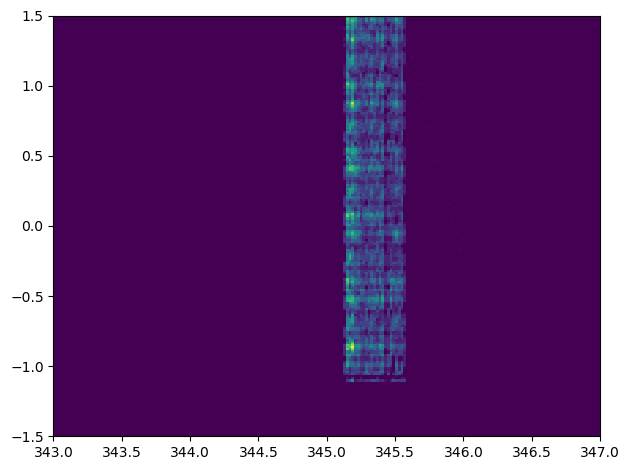

In [5]:
import os
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table

#otf = Table.read('/Users/cmartin/GUSTO/integrated-G345-2025-01-14.csv',header_start=0)
#otf = Table.read('/Users/cmartin/GUSTO/integrated-G355b-2025-01-13.csv',header_start=0)
otf = Table.read('/Volumes/GUSTO/integrated-G345-2025-03-27.csv',header_start=0)

import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

otfsel=(otf['GLON']<50)
otf['GLON'][otfsel] += 360

velocity_width=10
velocity_bins=np.arange(-150,110,velocity_width)
otf_vel_pwr=np.array([otf['VN150'],otf['VN140'],otf['VN130'],otf['VN120'],otf['VN110'],otf['VN100'],otf['VN090'],otf['VN080'],otf['VN070'],otf['VN060'],otf['VN050'],otf['VN040'],otf['VN030'],otf['VN020'],otf['VN010'],otf['VP000'],otf['VP010'],otf['VP020'],otf['VP030'],otf['VP040'],otf['VP050'],otf['VP060'],otf['VP070'],otf['VP080'],otf['VP090'],otf['VP100']])

fig, axs = plt.subplots(3,1)

axs[0].hist(otf['GLON'], bins=100,range=[250,370])
axs[1].hist(otf_vel_pwr[0,:], bins=100,range=[-100,500])
axs[2].hist(otf['TARMS'],  bins=100,range=[0,100])

plt.show

fig, ax = plt.subplots(tight_layout='true')

#hist = ax.hist2d(otf['GLON'],otf['GLAT'],bins=100,range=[[332,360],[-2,2]])
#hist = ax.hist2d(otf['GLON'],otf['GLAT'],bins=200)
hist = ax.hist2d(otf['GLON'],otf['GLAT'],bins=200,range=[[343,347],[-1.5,1.5]])

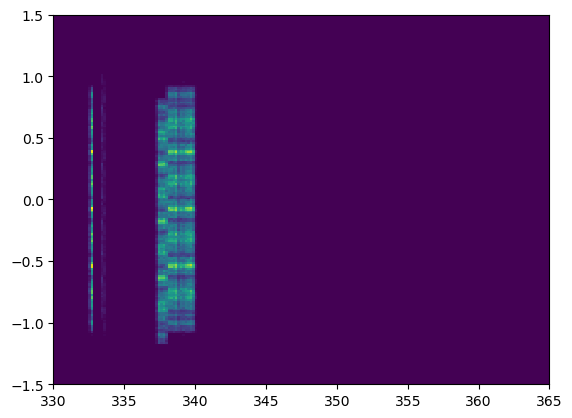

In [9]:
hist = plt.hist2d(otf['GLON'],otf['GLAT'],bins=200,range=[[330,365],[-1.5,1.5]])

In [3]:
print(otf_vel_pwr.shape,otfsel.shape,otf_vel_pwr[2,otfsel].shape)

(26, 41598) (41598,) (0,)


In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def make_otf_map(glon_min,glon_max,arcmin_spacing,direction,line,mixer,velocity_index,ax=None):
    if line=="CII":
        linefreq=1900537
    else:
        line="NII"
        linefreq=1461132
    if ax is None:
        ax = plt.gca()
    GLON_MIN, GLON_MAX=(glon_min, glon_max)
    if GLON_MAX < 50:
        GLON_MAX = GLON_MAX + 360
    GLAT_MIN, GLAT_MAX=(-1.0, 2.0)
    SPACING=arcmin_spacing/60
    nx, ny = (int((GLON_MAX-GLON_MIN)/SPACING)+1 , int((GLAT_MAX-GLAT_MIN)/SPACING)+1)
    x = np.linspace(GLON_MIN,GLON_MAX,nx)
    y = np.linspace(GLAT_MIN,GLAT_MAX,ny)
    xv , yv = np.meshgrid(x,y)
    
    otf_grid=np.zeros_like(xv)

    if direction=="both":
        otfsel=(otf['TARMS']<20) & (otf['LINEFREQ']==linefreq) & (otf['MIXER']==mixer)
    else:
        otfsel=(otf['TARMS']<20) & (otf['LINEFREQ']==linefreq) & (otf['SCANDIR']==direction) & (otf['MIXER']==mixer)
    otf2=otf[otfsel]
    otf_vel_pwr2=otf_vel_pwr[velocity_index,otfsel]

    for i, x in enumerate(xv):
        for j, y in enumerate(x):
            otfsel=(otf_vel_pwr2>-10) & (otf2['GLON']>xv[i,j]) & (otf2['GLON']<(xv[i,j]+SPACING)) & (otf2['GLAT']>yv[i,j]) & (otf2['GLAT']<(yv[i,j]+SPACING))
            otf3=otf2[otfsel]
            otf_vel_pwr3=otf_vel_pwr2[otfsel]
            otf_grid[i,j]=np.ma.mean(otf_vel_pwr3)
    hist = ax.pcolormesh(xv,yv,otf_grid,vmax=40)
    ax.title.set_text("%s mix:%d dir:%s vel:%.0f to %.0f km/s" % (line, mixer, direction, velocity_bins[velocity_index], velocity_bins[velocity_index]+10))
    ax.set_aspect('equal', adjustable='datalim')
    #plt.colorbar(hist,ax=ax)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlim((GLON_MAX,GLON_MIN))
    plt.gca().tick_params(color='black',labelcolor='black')
    plt.xlabel("Galactic Longitude",color='black')
    plt.ylabel("Galactic Latitude",color='black')
    cb = plt.colorbar(hist,location='bottom')
    cb.set_label("Integrated Intensity", color='black')
    cb.ax.xaxis.set_tick_params(color='black')
    cb.outline.set_edgecolor('black')
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='black')
    plt.savefig('G345-int-2025-01-12',transparent=True)
    return hist


  0%|                                                                                                                                         | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/GUSTO/lib/python3.11/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/opt/anaconda3/envs/GUSTO/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.80s/it]


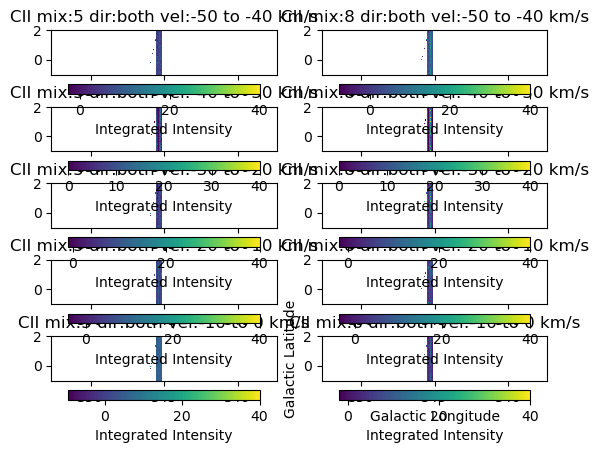

In [7]:
velstart=10
velslices=5
fig, axs = plt.subplots(velslices,2)
for velocity_index in tqdm(range(velstart,velstart+velslices)):
    make_otf_map(344,346,2,"both","CII",5,velocity_index,axs[velocity_index-velstart,0])
    make_otf_map(344,346,2,"both","CII",8,velocity_index,axs[velocity_index-velstart,1])

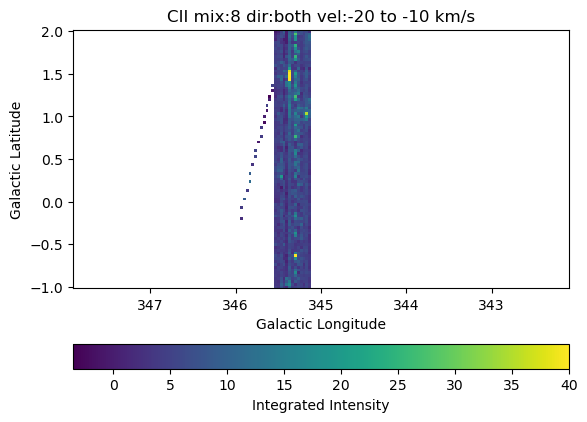

In [8]:
# For G355 this is the best plot
#make_otf_map(354,356,2,"both","CII",8,12)
# For G345
make_otf_map(344,346,2,"both","CII",8,13)

76it [00:03, 20.41it/s]
76it [00:03, 19.96it/s]
76it [00:09,  8.40it/s]
76it [00:08,  8.50it/s]
76it [00:05, 12.86it/s]
76it [00:06, 12.41it/s]
76it [00:07, 10.10it/s]
76it [00:07, 10.49it/s]
76it [00:09,  7.95it/s]
76it [00:08,  8.82it/s]
76it [00:06, 11.48it/s]
76it [00:06, 12.62it/s]


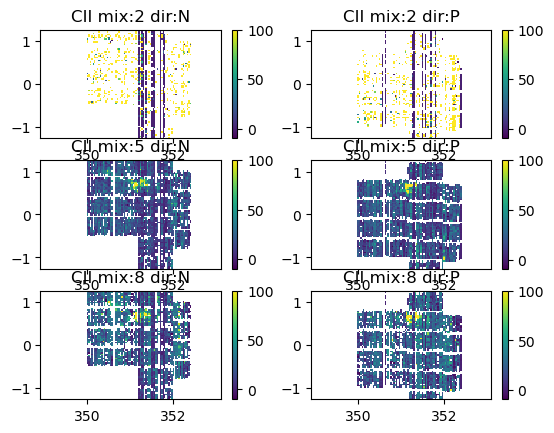

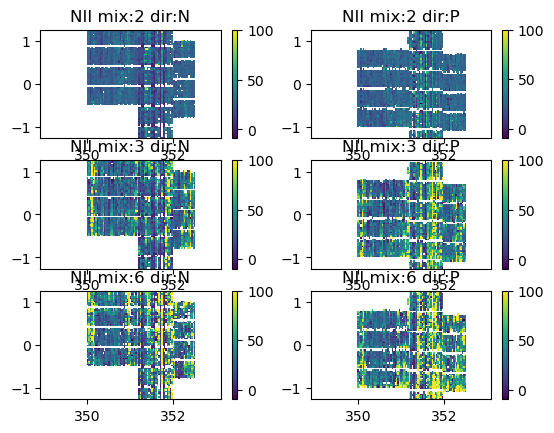

In [127]:
fig, axs = plt.subplots(3,2)
make_otf_map(349.5,352.5,2,"N","CII",2,axs[0,0]) # mixers 2 5 8
make_otf_map(349.5,352.5,2,"P","CII",2,axs[0,1]) 
make_otf_map(349.5,352.5,2,"N","CII",5,axs[1,0]) # mixers 2 5 8
make_otf_map(349.5,352.5,2,"P","CII",5,axs[1,1])
make_otf_map(349.5,352.5,2,"N","CII",8,axs[2,0]) # mixers 2 5 8
make_otf_map(349.5,352.5,2,"P","CII",8,axs[2,1])

fig, axs = plt.subplots(3,2)
make_otf_map(349.5,352.5,2,"N","NII",2,axs[0,0]) # mixers 2 3 6
make_otf_map(349.5,352.5,2,"P","NII",2,axs[0,1]) 
make_otf_map(349.5,352.5,2,"N","NII",3,axs[1,0])
make_otf_map(349.5,352.5,2,"P","NII",3,axs[1,1])
make_otf_map(349.5,352.5,2,"N","NII",6,axs[2,0])
make_otf_map(349.5,352.5,2,"P","NII",6,axs[2,1])

In [51]:
for velocity_index in tqdm(range(0,2)):
    print(velocity_index)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 5936.74it/s]

0
1


16it [00:01,  9.15it/s]
16it [00:01, 10.57it/s]
16it [00:03,  4.13it/s]
16it [00:03,  4.82it/s]
16it [00:03,  4.42it/s]
16it [00:03,  5.19it/s]


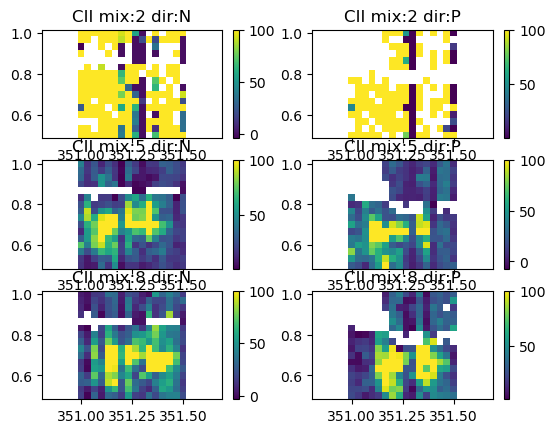

In [134]:
fig, axs = plt.subplots(3,2)
make_otf_map(351.0,351.5,2,"N","CII",2,axs[0,0]) # mixers 2 5 8
make_otf_map(351.0,351.5,2,"P","CII",2,axs[0,1]) 
make_otf_map(351.0,351.5,2,"N","CII",5,axs[1,0]) # mixers 2 5 8
make_otf_map(351.0,351.5,2,"P","CII",5,axs[1,1])
make_otf_map(351.0,351.5,2,"N","CII",8,axs[2,0]) # mixers 2 5 8
make_otf_map(351.0,351.5,2,"P","CII",8,axs[2,1])

76it [02:51,  2.26s/it]
76it [02:48,  2.21s/it]
76it [02:31,  2.00s/it]
76it [02:32,  2.01s/it]


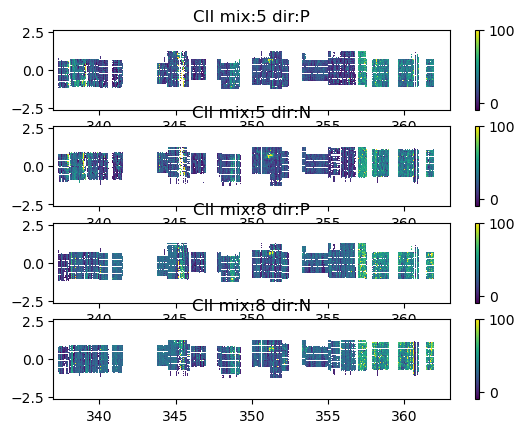

In [130]:
fig, axs = plt.subplots(4,1)
make_otf_map(337,363,2,"P","CII",5,axs[0])
make_otf_map(337,363,2,"N","CII",5,axs[1])
make_otf_map(337,363,2,"P","CII",8,axs[2])
make_otf_map(337,363,2,"N","CII",8,axs[3])

76it [00:07,  9.61it/s]
76it [00:06, 11.07it/s]
76it [00:26,  2.90it/s]
76it [00:24,  3.06it/s]
76it [00:24,  3.10it/s]
76it [00:23,  3.20it/s]
76it [00:14,  5.24it/s]
76it [00:14,  5.15it/s]
76it [00:13,  5.77it/s]
76it [00:12,  6.30it/s]
76it [00:14,  5.35it/s]
76it [00:13,  5.69it/s]


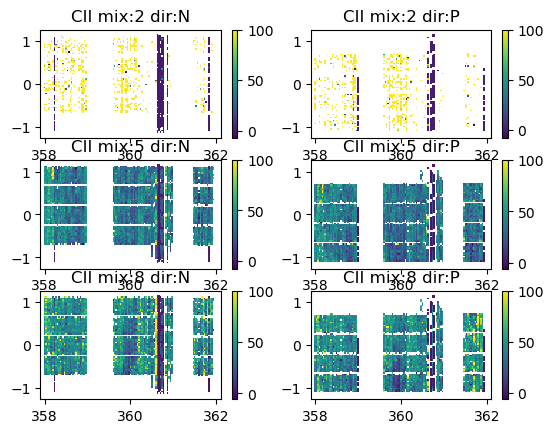

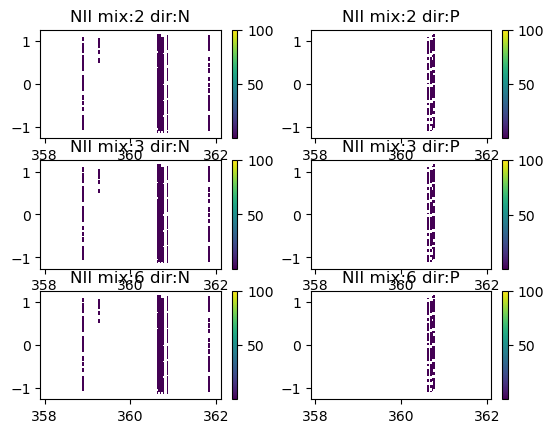

In [131]:
fig, axs = plt.subplots(3,2)
make_otf_map(358,362,2,"N","CII",2,axs[0,0]) # mixers 2 5 8
make_otf_map(358,362,2,"P","CII",2,axs[0,1]) 
make_otf_map(358,362,2,"N","CII",5,axs[1,0]) # mixers 2 5 8
make_otf_map(358,362,2,"P","CII",5,axs[1,1])
make_otf_map(358,362,2,"N","CII",8,axs[2,0]) # mixers 2 5 8
make_otf_map(358,362,2,"P","CII",8,axs[2,1])

fig, axs = plt.subplots(3,2)
make_otf_map(358,362,2,"N","NII",2,axs[0,0]) # mixers 2 3 6
make_otf_map(358,362,2,"P","NII",2,axs[0,1]) 
make_otf_map(358,362,2,"N","NII",3,axs[1,0])
make_otf_map(358,362,2,"P","NII",3,axs[1,1])
make_otf_map(358,362,2,"N","NII",6,axs[2,0])
make_otf_map(358,362,2,"P","NII",6,axs[2,1])